In [1]:
! pip install pywph==1.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pywph as pw
import numpy as np
import torch
import scipy.optimize as opt
import time

Reason for being yanked: Wrong requirements.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
params = pd.read_csv('drive/MyDrive/camels data/params.csv')
nbody_file = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')

In [4]:
full_params = params.loc[params.index.repeat(15)] # from len=1000 to len=15000
full_params = full_params.to_numpy()
wph_coeffs_1000 = np.load('drive/MyDrive/camels data/wph_coeffs.npy')

In [5]:
nbody_file.shape

(15000, 256, 256)

In [6]:
M = 256
N = 256
J = 7
L = 4
dn =0
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)

if torch.cuda.is_available():
    wph_op.to(0)

data = np.log(nbody_file)

In [7]:
data[0].shape

(256, 256)

In [ ]:
num = 1000
norm = None
wph_coeffs_1000 = np.zeros((num*15,520),dtype='complex')
#wph = wph_op(data, pbc=True, norm='auto', ret_wph_obj=True)

#for i in range(0,num):
#  if i%50==0: print(i)
#  test_coeff = wph_op(data[(i*15):(i*15+15)], norm=norm, pbc=True)
#  wph_coeffs_1000[(i*15):(i*15+15)] = test_coeff.cpu()


In [ ]:
#np.save('drive/MyDrive/camels data/wph_coeffs.npy', wph_coeffs_1000) #norm = None
#np.load('drive/MyDrive/camels data/wph_coeffs.npy')


In [8]:
wph = wph_op(data[0], ret_wph_obj=True, norm=None)
S11_shape = (wph.get_coeffs("S11")[0].shape)[0]
S00_shape = (wph.get_coeffs("S00")[0].shape)[0]
S01_shape = (wph.get_coeffs("S01")[0].shape)[0]
C01_shape = (wph.get_coeffs("C01")[0].shape)[0]
Cphase_shape = (wph.get_coeffs("Cphase")[0].shape)[0]
L_shape = (wph.get_coeffs("L")[0].shape)[0]


In [9]:
real_coeffs = wph_coeffs_1000.real
imag_coeffs = wph_coeffs_1000.imag
# use real part only here

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [25]:
# normalise
#scaler = MinMaxScaler()
#real_coeffs = scaler.fit_transform(real_coeffs)
#full_params = scaler.fit_transform(full_params)


In [11]:
num_samples, num_params= np.shape(full_params)
num_samples, num_coeffs = np.shape(real_coeffs)

coeffs_train, coeffs_test, params_train, params_test = train_test_split(real_coeffs, full_params,
                                                                    test_size=0.1, random_state=42)

In [16]:
model = keras.Sequential([
    layers.Input(shape=(num_coeffs,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_params)
])

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(512, activation='relu', input_shape=(num_coeffs,)),
#    tf.keras.layers.BatchNormalization(synchronized=True),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='relu'),
#    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l1'),
#    tf.keras.layers.Dense(6),
#])

In [17]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
train = model.fit(coeffs_train, params_train, epochs=30, batch_size=16,
                  validation_data=(coeffs_test, params_test))

Epoch 1/30
844/844 [==============================] - 2s 2ms/step - loss: 1.3797 - accuracy: 0.3172 - val_loss: 0.5149 - val_accuracy: 0.3240
Epoch 2/30
844/844 [==============================] - 2s 2ms/step - loss: 0.4684 - accuracy: 0.3179 - val_loss: 0.4401 - val_accuracy: 0.3307
Epoch 3/30
844/844 [==============================] - 2s 2ms/step - loss: 0.4386 - accuracy: 0.3188 - val_loss: 0.4260 - val_accuracy: 0.3247
Epoch 4/30
844/844 [==============================] - 2s 2ms/step - loss: 0.4300 - accuracy: 0.3196 - val_loss: 0.4197 - val_accuracy: 0.3220
Epoch 5/30
844/844 [==============================] - 2s 2ms/step - loss: 0.4258 - accuracy: 0.3221 - val_loss: 0.4175 - val_accuracy: 0.3167
Epoch 6/30
844/844 [==============================] - 2s 2ms/step - loss: 0.4230 - accuracy: 0.3240 - val_loss: 0.4145 - val_accuracy: 0.3167
Epoch 7/30
844/844 [==============================] - 2s 2ms/step - loss: 0.4212 - accuracy: 0.3191 - val_loss: 0.4124 - val_accuracy: 0.3207
Epoch 

In [18]:
predictions = model.predict(coeffs_test)
loss = train.history['loss']
val_loss = train.history['val_loss']
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']

47/47 [==============================] - 0s 1ms/step


Text(0.5, 0, 'number of epochs')

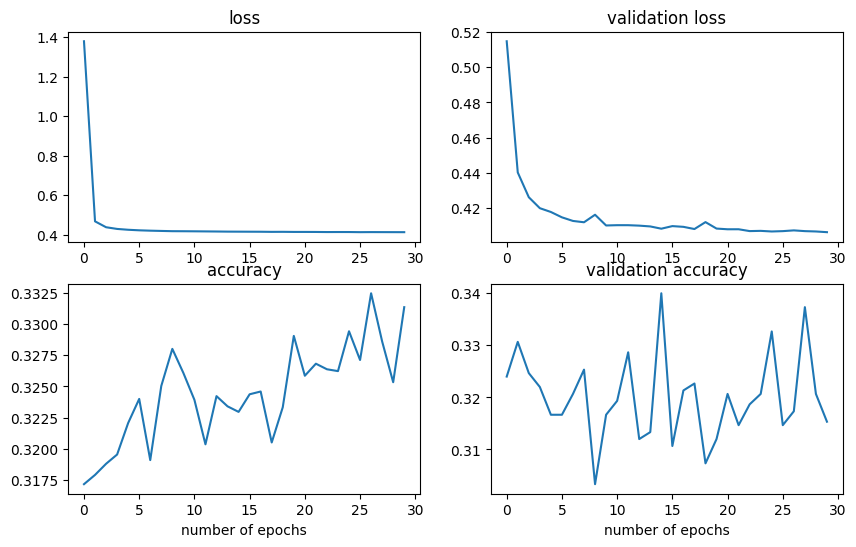

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0,0].plot(loss)
axs[0,1].plot(val_loss)
axs[1,0].plot(accuracy)
axs[1,1].plot(val_accuracy)

axs[0,0].set_title('loss')
axs[0,1].set_title('validation loss')
axs[1,0].set_title('accuracy')
axs[1,1].set_title('validation accuracy')

axs[1,0].set_xlabel('number of epochs')
axs[1,1].set_xlabel('number of epochs')

In [20]:
print(predictions.shape)
print(params_test.shape)

(1500, 6)
(1500, 6)


In [21]:
# coefficients predicted
pd.DataFrame(predictions)

,0,1,2,3,4,5
0,0.213963,0.742325,1.378572,1.375376,1.078102,1.111868
1,0.380769,0.928141,1.339824,1.459243,1.069899,1.145244
2,0.338567,0.834511,1.291646,1.307790,1.056590,1.045292
3,0.254646,0.746087,1.376720,1.381963,1.087473,1.071516
4,0.111231,0.640467,1.211925,1.281115,1.002786,1.036027
...,...,...,...,...,...,...
1495,0.281285,0.799524,1.284943,1.272666,1.004022,1.067731
1496,0.271773,0.773060,1.390625,1.371172,1.088618,1.090054
1497,0.168286,0.700244,1.297313,1.332618,1.035828,1.074507
1498,0.244673,0.773157,1.270519,1.304032,1.024004,1.080476


In [22]:
pd.DataFrame(params_test)

,0,1,2,3,4,5
0,0.1842,0.6438,0.41123,0.40109,0.51370,0.82074
1,0.3658,0.9690,1.62225,0.50069,0.92338,1.83147
2,0.2138,0.9698,0.62851,1.46409,1.68296,1.14472
3,0.3874,0.6946,0.60626,1.16312,1.30767,0.69112
4,0.1346,0.6182,0.61643,2.07053,1.57680,1.73748
...,...,...,...,...,...,...
1495,0.2714,0.7738,1.00417,0.74639,0.98966,0.69207
1496,0.3378,0.6542,2.63536,3.23553,1.77645,1.45902
1497,0.1302,0.7246,0.28837,0.68492,0.70662,0.94540
1498,0.1970,0.8166,0.28440,0.97400,1.14631,1.06363


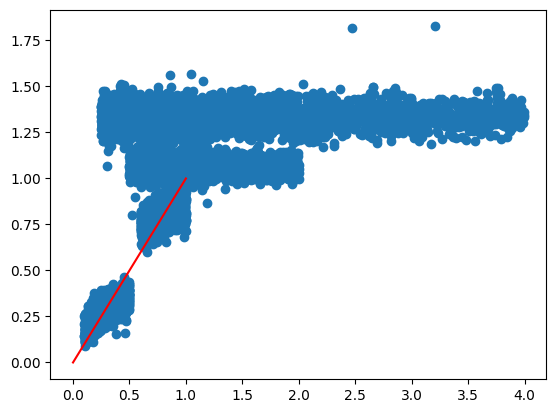

In [25]:
plt.scatter(params_test,predictions)
x = np.linspace(0,1,21)
y = x
plt.plot(x,y,'r')